# FSI problem

### This is a FSI problem of 1-D falling plate in quiscent flow.

In [1]:
using Pkg
Pkg.activate("..")
using FSI

In [2]:
using Revise
using BSON: @save, @load

using Plots
pyplot()
clibrary(:colorbrewer)
default(grid = false)

In [3]:
filename = "FallingPlate";

## <span style="color:blue"> Set up rigid body with Dyn3d

#### Include any joint-body setup script from Dyn3d

In [4]:
# problem dimension
ndim = 2
# numerical params
tf = 6
dt = 1e-3
scheme = "Liska"
st = 3
tol = 1e-4
num_params = NumParams(tf, dt, scheme, st, tol)
# gravity
gravity = [0., -1.0, 0.]

# set up system config info
config_system = ConfigSystem(ndim, gravity, num_params)

# set up bodys
nbody = 1
config_body = ConfigBody(nbody, 4,
   [0. 0.; 1. 0.; 1. 1.0/nbody; 0. 1.0/nbody], 2.0)
config_bodys = fill(config_body, nbody)

# set up joints
njoint = nbody

config_joints = Vector{ConfigJoint}(undef,njoint)

# set the first passive joint with no stiff and damp
dof_1 = Dof(5, "passive", 0., 0., Motions())

config_joints[1] = ConfigJoint(njoint, "custom_prismatic_in_y",
    [0.,0.,0.,0.5,2.5,0.], zeros(Float64,6), 0, [dof_1], [0.])

 joint type = custom_prismatic_in_y
 joint position in parent body coord = [0.0, 0.0, 0.0, 0.5, 2.5, 0.0]
 joint position in child body coord = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 joint unconstrained dof = 5, under passive motion
 initial unconstrained dof position = [0.0]


#### Build joint-body chain

In [5]:
bs, js, bsys = BuildChain(config_bodys, config_joints, config_system)
bd = BodyDyn(bs, js, bsys)

This is a 1 body-joint system, system is un-mounted from space

#### Initialize rigid body system state to complete body-joint information

In [6]:
bd, soln₀ = InitSystem!(bd);

#### Initialize u and λ container

In [7]:
qJ = soln₀.qJ
v = soln₀.v
λ_dim = bd.sys.ncdof_HERK
λ = zeros(Float64,λ_dim);

#### Get body verts for plotting

In [8]:
@get bd (bs, js, sys)
bs, js, sys = UpdatePosition!(bs, js, sys, soln₀.qJ)
vs₀ = VertsHistory(sys.nbody, bs);

#### Plot body only

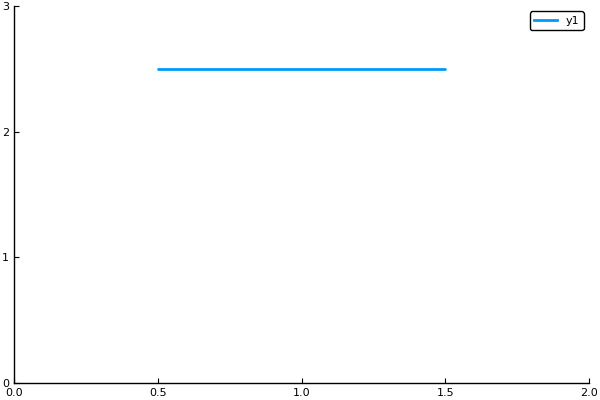

In [9]:
p = plot()
for i = 1:sys.nbody
    plot!(p,vs₀[i,2:3,1], vs₀[i,2:3,2],linewidth=2)
end
plot!(xlims=(0,2), ylims=(0,3))

## <span style="color:blue"> Set up fluid with Whirl </span>

#### Set the flow parameters

In [10]:
Re = 200 # Reynolds number
U = 0.0 # Free stream velocity
U∞ = (0.0, U)

(0.0, 0.0)

#### Set the domain grid

In [11]:
nx = 102; ny = 152;
Ly = 3.0;
Δx = Ly/(ny-2);
Δt = min(0.5*Δx,0.5*Δx^2*Re)
w₀ = Nodes(Dual,(nx,ny))
xg, yg = coordinates(w₀,dx=Δx)

(-0.01:0.02:2.0100000000000002, -0.01:0.02:3.0100000000000002)

#### Set up fluid initial conditions

In [12]:
w₀ .= 0.0;
w = deepcopy(w₀);

## <span style="color:blue"> Create fluid-body interface </span>

#### Genrate body grid points and get linear velocity on them

In [13]:
# bgs short for body grid system
bgs = GenerateBodyGrid(bd; np=DetermineNP(nbody, Δx))
bgs = CutOut2d(bd,bgs);

#### Get body points initial coordinates for fluids

In [14]:
bgs = AcquireBodyGridKinematics(bd,bgs)
coord_init = hcat(bgs[1].q_i...)'[:,[1,2]]
for i = 2:length(bgs)
    coord_init = [coord_init[1:end-1,:]; hcat(bgs[i].q_i...)'[:,[1,2]]]
end

#### Set up body grid points and force container in fluid

In [15]:
X̃ = VectorData(coord_init)
f = VectorData(X̃);

#### Create fluidstruct structure

In [16]:
tf = 30Δt
T = Δt:Δt:tf
fsys = FluidStruct((nx,ny),Re,Δx,Δt,U∞ = U∞, X̃ = X̃, rk=RK31)
N = length(X̃)÷2

51

## <span style="color:blue"> Create ifherk object </span>

#### pretend that this thin body has finite volume for buoyancy

In [17]:
function TimeMarching.F(bd::BodyDyn)
    f_exi = zeros(Float64,bd.sys.nbody,6)
    return HERKFuncf(bd.bs, bd.js, bd.sys, f_exi)
end

In [18]:
@time ifherk_coupled = FSI.IFHERK_coupled(fsys.Δt,bd,bgs,(w₀,qJ,v,f,λ),
                ((t,u) -> Systems.plan_intfact(t,u,fsys), B₁ᵀ, B₂),
                (M⁻¹, G₁ᵀ, G₂, UpP, UpV),
                ((bd,bgs,f) -> T₁ᵀ(bd,bgs,f,fsys.Δx), (bd,bgs,u) -> T₂(bd,bgs,u), (bd,bgs) -> getX̃(bd,bgs)),
                ((w,t) -> r₁(w,t,fsys), F, w -> U_inf(w,fsys), gti),
                fsys, tol=1e-3,rk=TimeMarching.RK31)

  8.658943 seconds (73.81 M allocations: 2.457 GiB, 7.14% gc time)


Stage-3+ IF-HERK integrator with
   Time step size 0.01


In [19]:
fx = Float64[]
fy = Float64[]
thist = []
t = 0.0
whist = []
bdhist = BodyDyn[];

## <span style="color:blue"> TimeMarching! </span>

In [20]:
@time for ti in T
    
    @time global t, (w, f), (qJ, v, λ), bd = ifherk_coupled(t, w, qJ, v, bd,fsys)
    
    push!(thist,t-Δt)
    push!(fx,sum(f.u)*Δx^2)
    push!(fy,sum(f.v)*Δx^2)
    push!(whist,deepcopy(w))
    push!(bdhist,deepcopy(bd))
    println("next time unit is $(round(t,digits=3))")
    
    if mod(ti/Δt,200) == 1  
        @save filename*".bson" bd bdhist xg yg whist thist fx fy Δt w qJ v
        println("data saved at time ", ti)
    end
end

  5.904773 seconds (61.33 M allocations: 1.868 GiB, 6.91% gc time)
next time unit is 0.01
data saved at time 0.01
  4.533550 seconds (58.03 M allocations: 1.710 GiB, 9.07% gc time)
next time unit is 0.02
  4.335859 seconds (58.03 M allocations: 1.710 GiB, 6.51% gc time)
next time unit is 0.03
  4.312131 seconds (58.03 M allocations: 1.710 GiB, 6.57% gc time)
next time unit is 0.04
  4.329429 seconds (58.03 M allocations: 1.710 GiB, 6.57% gc time)
next time unit is 0.05
  4.360876 seconds (58.03 M allocations: 1.710 GiB, 6.63% gc time)
next time unit is 0.06
  4.363497 seconds (58.03 M allocations: 1.710 GiB, 6.67% gc time)
next time unit is 0.07
  4.477256 seconds (58.03 M allocations: 1.710 GiB, 6.79% gc time)
next time unit is 0.08
  4.420622 seconds (58.03 M allocations: 1.710 GiB, 6.76% gc time)
next time unit is 0.09
  4.740044 seconds (58.03 M allocations: 1.710 GiB, 6.61% gc time)
next time unit is 0.1
  4.335270 seconds (58.03 M allocations: 1.710 GiB, 6.75% gc time)
next time 

## <span style="color:blue"> Plot </span>

#### Set contour levels and fps

In [5]:
contour_levels = range(-0.2,stop=0.2,length=40)
sample_freq = 2
fps = 25;

#### Get body verts history

In [6]:
# get verts info based on this regular grid solution
vshist = []
for i = 1:length(bdhist)
    @get bdhist[i] (bs, js, sys)
    push!(vshist, VertsHistory(sys.nbody, bs))
end

#### Plot first and last time field

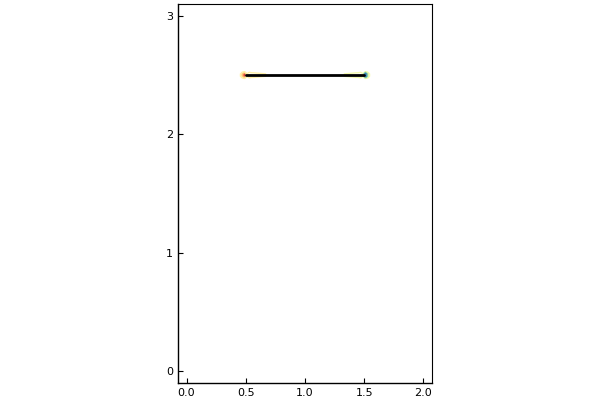

In [7]:
p = plot(xg,yg,whist[1],levels=contour_levels)
for i = 1:bd.sys.nbody
    plot!(p,vshist[1][i,2:3,1], vshist[1][i,2:3,2],linewidth=2,linecolor="black")
end
p

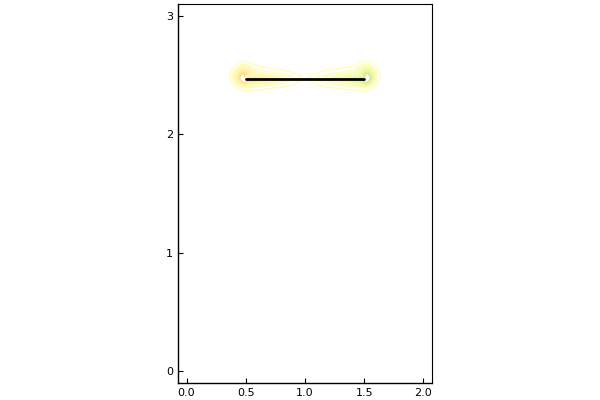

In [8]:
p = plot(xg,yg,whist[end],levels=contour_levels)
for i = 1:bd.sys.nbody
    plot!(p,vshist[end][i,2:3,1], vshist[end][i,2:3,2],linewidth=2,linecolor="black")
end
# savefig(p,"plate.eps")
p

#### Body position begining and end

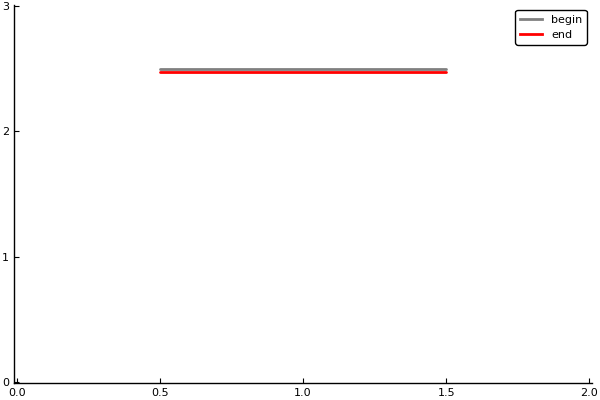

In [9]:
pb = plot()
for i = 1:sys.nbody
    plot!(pb,vshist[1][i,2:3,1], vshist[1][i,2:3,2],linewidth=2,linecolor="grey",label="begin")
end
for i = 1:sys.nbody
    plot!(pb,vshist[end][i,2:3,1], vshist[end][i,2:3,2],linewidth=2,linecolor="red",label="end")
end
plot!(pb,xlims=(xg[1],xg[end]), ylims=(yg[1],yg[end]))
pb

#### Make gif

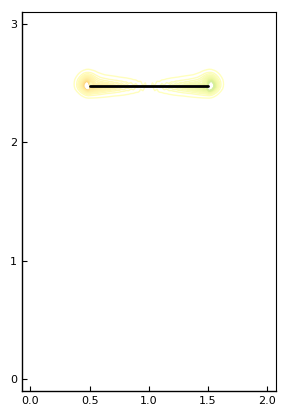

┌ Info: Saved animation to 
│   fn = /mnt/g/Research/FSI.jl/examples/FallingPlate.gif
└ @ Plots /home/fs/.julia/packages/Plots/oiirH/src/animation.jl:90


Plots.AnimatedGif("/mnt/g/Research/FSI.jl/examples/FallingPlate.gif")

In [10]:
anim = @animate for j = 1:sample_freq:length(whist)
    plot(xg,yg,whist[j],levels=contour_levels)
    for i = 1:sys.nbody
        plot!(vshist[j][i,2:3,1], vshist[j][i,2:3,2],linewidth=2,linecolor="black")
    end
end

gif(anim, filename*".gif", fps = fps)

#### Get position, velocity and acceleration in time

In [11]:
vhist = [0.0]
phist = [0.0]

for i in 1:length(bdhist)
    push!(vhist,bdhist[i].bs[1].v[5])
    push!(phist,bdhist[i].bs[1].x_i[2]-bdhist[1].bs[1].x_i[2])    
end

ahist = []
for i in 1:length(vhist)-1
    push!(ahist,(vhist[i+1]-vhist[i])/Δt)
end

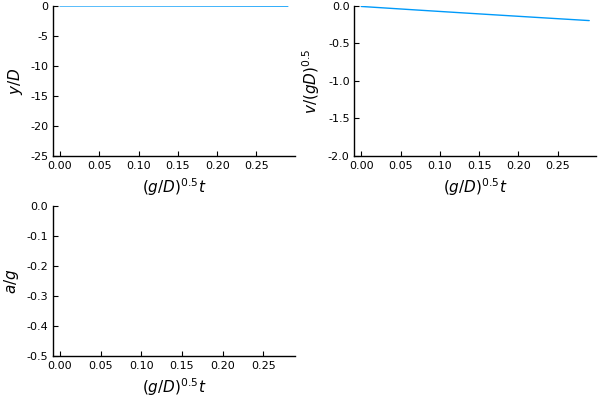

In [12]:
pp = plot([0.0;thist],phist,xlabel="\$(g/D)^{0.5}t \$",ylabel="\$y/D\$",legend=false,ylims=(-25,0))
pv = plot([0.0;thist],vhist,xlabel="\$(g/D)^{0.5}t \$",ylabel="\$v/(gD)^{0.5}\$",legend=false,ylims=(-2,0))
pa = plot([0.0;thist[1:end-1]],ahist,xlabel="\$(g/D)^{0.5}t \$",ylabel="\$a/g\$",legend=false,ylims=(-0.5,0))

plot(pp,pv,pa)

In [13]:
ahist[1:5]

5-element Array{Any,1}:
 -0.68376659669561  
 -0.6796889531931251
 -0.676124635946489 
 -0.672938974888982 
 -0.670037104842005 

#### Lift and drag coefficients

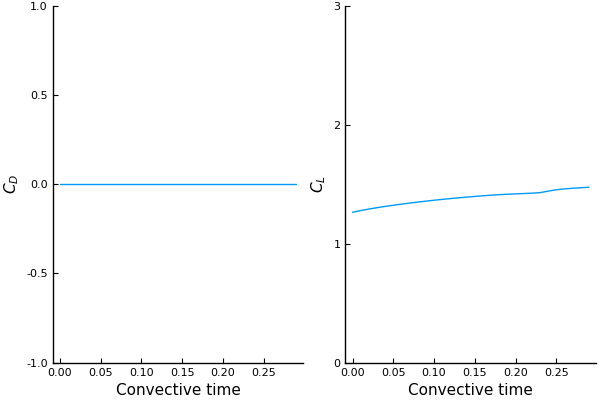

In [14]:
px = plot(thist,2*fx,ylim=(-1,1),xlabel="Convective time",ylabel="\$C_D\$",legend=false)
py = plot(thist,2*fy,ylim=(0,3),xlabel="Convective time",ylabel="\$C_L\$",legend=false)
plot(px,py)

## <span style="color:blue"> Save Data </span>

#### Save all current data related to plotting to a .jld file

In [15]:
@save filename*".bson" bd bdhist xg yg whist vshist thist fx fy Δt w qJ v

#### Use the following block to extract data

In [16]:
# using Dyn3d
# using ViscousFlow

# @load filename*".bson" bd bdhist xg yg whist vshist thist fx fy Δt w qJ v
# @get bd (bs,js,sys);